**This Project is to predict temperature in the subsurface for geothermal energy applications. The bottomhole temperature at the bottom of an existing wellbore drilled for oil and gas application can be used to map the subsurface temperatures, which can then be used for creating geothermal heat maps**

**File Import**

In [93]:
#importing the data file
import numpy as np
import pandas as pd
term = pd.read_excel('AASG_Geothermal.xlsx')
term

,LatDegree,LongDegree,MeasureDepth_m,SurfTemp,BHT_C
0,38.460130,-82.721020,529.13,14.05,31.11
1,38.459500,-82.716841,529.74,14.05,30.00
2,38.454476,-82.712581,655.62,14.05,30.00
3,38.443355,-82.714851,651.97,14.05,28.33
4,38.424684,-82.710950,576.99,14.05,29.44
...,...,...,...,...,...
194,37.574906,-82.629020,617.22,14.69,23.89
195,37.441298,-82.598967,746.76,14.88,23.33
196,37.617216,-82.748619,767.49,14.47,25.56
197,37.383883,-82.712743,914.10,14.99,26.11


In [94]:
#converting the term details to array
project = term.values
project

array([[  38.46013 ,  -82.72102 ,  529.13    ,   14.05    ,   31.11    ],
       [  38.4595  ,  -82.716841,  529.74    ,   14.05    ,   30.      ],
       [  38.454476,  -82.712581,  655.62    ,   14.05    ,   30.      ],
       [  38.443355,  -82.714851,  651.97    ,   14.05    ,   28.33    ],
       [  38.424684,  -82.71095 ,  576.99    ,   14.05    ,   29.44    ],
       [  38.470619,  -82.708903,  573.94    ,   14.05    ,   27.22    ],
       [  38.453101,  -82.725886,  639.78    ,   14.05    ,   23.33    ],
       [  38.451373,  -82.723267,  670.56    ,   14.05    ,   26.67    ],
       [  38.4419  ,  -82.718063,  661.11    ,   14.05    ,   29.44    ],
       [  38.414223,  -82.728483,  572.41    ,   13.96    ,   25.56    ],
       [  38.425864,  -82.737407,  540.72    ,   14.05    ,   43.33    ],
       [  38.417847,  -82.760619,  545.59    ,   14.1     ,   20.56    ],
       [  38.429707,  -82.750933,  515.11    ,   14.05    ,   23.33    ],
       [  38.35519 ,  -82.670782,  963

**Assigning Features and Targets**

In [95]:
#splitting the array into features and target variables
X = project[:,:4]
y = project[:,4:]
print("No.of Samples : ", X.shape[0])
print("No.of Features : ", X.shape[1])

No.of Samples :  199
No.of Features :  4


**Train and Test Split for the model**

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

**Outlier Detection by Isolation Forest**

In [97]:
from sklearn.ensemble import IsolationForest
outlier = IsolationForest(contamination=0.03,max_samples=0.8,max_features=1.0,random_state=42)
outlier.fit(X_train)
train_predict = outlier.predict(X_train)
test_predict = outlier.predict(X_test)
X_train_i = X_train[train_predict==1] #Separating the inlier datapoints for training dataset
y_train_i = y_train[train_predict==1]
X_test_i = X_test[test_predict==1] #Separating the inlier datapoints for test dataset
y_test_i = y_test[test_predict==1]
outlier_values = X_train[train_predict==-1] #Separating the outlier from the training data


**Exporting the Outliers**

In [98]:
import pickle

filename = 'Prediction_Outliers.sav'

pickle.dump(outlier,open(filename,'wb'))

**Scaling using Standard Scaler**

In [99]:
## train scaler 
from sklearn.preprocessing import StandardScaler
scl= StandardScaler()
scl.fit(X_train_i)
# scaling using train and test data
X_train_i_s = scl.transform(X_train_i)
X_test_i_s = scl.transform(X_test_i)

**Exporting the Scaler**

In [100]:
filename = 'Prediction_Scalers.sav'
pickle.dump(scl,open(filename,'wb'))

**Models Initialization and Hyperparameter Tuning**

In [101]:
#Model Creation using dictionary because of five models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

reg_models ={"RFR": RandomForestRegressor(),"SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "ENet": ElasticNet(),
    "GBR": GradientBoostingRegressor()}

#setting the hyperparameters to find the best models

param_grid = {"RFR" : {'min_samples_leaf': [2, 5], 'max_depth':[4,7,9], 'max_features':[2,3,4], 'n_estimators':[50, 150,300]},
             "SVR" : {'C': [0.1,1,10], 'kernel':['linear','rbf','poly'], 'epsilon':[0.1,0.2,0.3], 'degree':[2,3,4]},
             "KNN" : {'n_neighbors': [3,5,7,9],'weights': ['uniform','distance']},
             "ENet" : {'alpha':  [0.01, 0.1, 1, 10, 100], 'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9],'max_iter':[2000]},
             "GBR" : {'n_estimators': [100,200,300], 'learning_rate':[0.01,0.1,0.2], 'max_depth':[3,4,5],'min_samples_split': [2,5,10]}}

**Model Training and Selecting the Best Model based on Hyperparamters**

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
cv_models= KFold(n_splits=5,shuffle=True)
best_models = {}
best_models_mae = {}
for model_name,model in reg_models.items():
    grid = GridSearchCV(model, param_grid[model_name],cv=cv_models,verbose=3)
    grid.fit(X_train_i_s,y_train_i)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model
    y_pred = best_model.predict(X_test_i_s)
    mae = mean_absolute_error(y_test_i, y_pred)
    best_models_mae[model_name] = best_model
    best_models_mae[model_name] = {'model': model, 'mae': mae,'hyperparameters': grid.best_estimator_}

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.492 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.518 total time=   0.0s
[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=50;, score=-0.043 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.044 total time=   0.0s
[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.416 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.532 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.510 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.037 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.080 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.389 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.513 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.509 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.092 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.081 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.397 total time=   0.3s
[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.486 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.524 total time=   0.0s
[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.085 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.080 total time=   0.0s
[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.344 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.499 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.482 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.048 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.073 total time=   0.1s
[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.394 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.483 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.465 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.062 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.057 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.388 total time=   0.4s
[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.519 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.534 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.021 total time=   0.0s
[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.145 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.430 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.493 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.532 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.004 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.143 total time=   0.2s
[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.434 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.486 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.529 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=300;, score=-0.002 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.116 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.432 total time=   0.3s
[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.466 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.567 total time=   0.0s
[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=50;, score=-0.010 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.152 total time=   0.0s
[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.450 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.491 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.540 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.024 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.142 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.424 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.459 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.540 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.014 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.177 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.457 total time=   0.3s
[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.469 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.547 total time=   0.0s
[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=50;, score=-0.017 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.155 total time=   0.0s
[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.437 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.455 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.552 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=150;, score=-0.036 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.219 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.473 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.466 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.535 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=300;, score=-0.033 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.169 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.455 total time=   0.3s
[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.418 total time=   0.0s
[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.563 total time=   0.0s
[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=50;, score=-0.040 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.244 total time=   0.0s
[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.460 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.459 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.530 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=150;, score=-0.065 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.202 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.494 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.411 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.541 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=300;, score=-0.034 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.175 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=4, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.489 total time=   0.3s
[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.406 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.509 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=50;, score=-0.017 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.087 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.426 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.462 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.547 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.057 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.100 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.434 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.475 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.546 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.055 total time=   0.6s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.134 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.427 total time=   0.3s
[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.485 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.490 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.059 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.107 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.373 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.494 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.538 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.042 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.109 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.419 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.482 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.490 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.068 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.139 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.421 total time=   0.3s
[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.455 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.535 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.004 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.165 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.483 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.481 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.518 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=150;, score=-0.014 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.150 total time=   0.1s
[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.455 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.480 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.556 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=300;, score=-0.043 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.161 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.437 total time=   0.3s
[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.464 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.500 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=50;, score=-0.005 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.193 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.494 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.402 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.509 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.046 total time=   0.1s
[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.165 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.469 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.468 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.531 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.035 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.159 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.465 total time=   0.3s
[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.419 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.578 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=50;, score=-0.128 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.194 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.449 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.400 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.561 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=150;, score=-0.061 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.172 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.487 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.440 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.568 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=300;, score=-0.092 total time=   0.7s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.196 total time=   0.6s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.460 total time=   0.6s
[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.382 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.562 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=50;, score=-0.071 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.211 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.463 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.405 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.557 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.041 total time=   0.1s
[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.242 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.503 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.402 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.560 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=300;, score=-0.016 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.206 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=7, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.509 total time=   0.3s
[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.495 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.523 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.054 total time=   0.0s
[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.051 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=50;, score=0.393 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.517 total time=   0.1s
[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.528 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.042 total time=   0.1s
[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.154 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=150;, score=0.384 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.517 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.562 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.020 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.133 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=2, n_estimators=300;, score=0.425 total time=   0.3s
[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.492 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.487 total time=   0.0s
[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.049 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.103 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=50;, score=0.388 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.504 total time=   0.1s
[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.484 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.071 total time=   0.1s
[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.151 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=150;, score=0.400 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.471 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.499 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.077 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.123 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=2, min_samples_leaf=5, n_estimators=300;, score=0.405 total time=   0.3s
[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.444 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.499 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=50;, score=-0.048 total time=   0.0s
[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.245 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=50;, score=0.389 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.470 total time=   0.1s
[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.538 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.000 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.205 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=150;, score=0.448 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.485 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.558 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=300;, score=-0.032 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.164 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=2, n_estimators=300;, score=0.437 total time=   0.6s
[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.428 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.522 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=50;, score=-0.010 total time=   0.0s
[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.183 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=50;, score=0.482 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.428 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.540 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.011 total time=   0.1s
[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.178 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=150;, score=0.484 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.439 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.537 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.057 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.198 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.458 total time=   0.3s
[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.468 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.581 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=50;, score=-0.098 total time=   0.0s
[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.094 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=50;, score=0.408 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.424 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.567 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=150;, score=-0.071 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.192 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=150;, score=0.466 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.437 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.548 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=300;, score=-0.087 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.151 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=2, n_estimators=300;, score=0.463 total time=   0.4s
[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.322 total time=   0.0s
[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.580 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=50;, score=-0.055 total time=   0.0s
[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.217 total time=   0.0s
[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=50;, score=0.498 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.405 total time=   0.1s
[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.561 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=150;, score=-0.001 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.220 total time=   0.1s
[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=150;, score=0.503 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.400 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.554 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=300;, score=-0.000 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.209 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END max_depth=9, max_features=4, min_samples_leaf=5, n_estimators=300;, score=0.517 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END C=0.1, degree=2, epsilon=0.1, kernel=linear;, score=-0.032 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, epsilon=0.1, kernel=linear;, score=0.495 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, epsilon=0.1, kernel=linear;, score=0.495 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, epsilon=0.1, kernel=linear;, score=0.348 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, epsilon=0.1, kernel=linear;, score=0.199 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, epsilon=0.1, kernel=rbf;, score=0.003 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, epsilon=0.1, kernel=rbf;, score=0.041 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, epsilon=0.1, kernel=rbf;, score=0.065 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, epsilon=0.1, kernel=rbf;, score=-0.082 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, epsilon=0.1, kernel=rbf;, score=0.069 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, epsilon=0.1, kernel=p

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 5/5] END C=0.1, degree=3, epsilon=0.3, kernel=rbf;, score=0.063 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, epsilon=0.3, kernel=poly;, score=0.012 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, epsilon=0.3, kernel=poly;, score=0.580 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, epsilon=0.3, kernel=poly;, score=0.617 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, epsilon=0.3, kernel=poly;, score=0.407 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, epsilon=0.3, kernel=poly;, score=0.026 total time=   0.0s
[CV 1/5] END C=0.1, degree=4, epsilon=0.1, kernel=linear;, score=-0.032 total time=   0.0s
[CV 2/5] END C=0.1, degree=4, epsilon=0.1, kernel=linear;, score=0.495 total time=   0.0s
[CV 3/5] END C=0.1, degree=4, epsilon=0.1, kernel=linear;, score=0.495 total time=   0.0s
[CV 4/5] END C=0.1, degree=4, epsilon=0.1, kernel=linear;, score=0.348 total time=   0.0s
[CV 5/5] END C=0.1, degree=4, epsilon=0.1, kernel=linear;, score=0.199 total time=   0.0s
[CV 1/5] END C=0.1, de

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 1/5] END C=1, degree=2, epsilon=0.2, kernel=rbf;, score=0.001 total time=   0.0s
[CV 2/5] END C=1, degree=2, epsilon=0.2, kernel=rbf;, score=0.322 total time=   0.0s
[CV 3/5] END C=1, degree=2, epsilon=0.2, kernel=rbf;, score=0.362 total time=   0.0s
[CV 4/5] END C=1, degree=2, epsilon=0.2, kernel=rbf;, score=0.321 total time=   0.0s
[CV 5/5] END C=1, degree=2, epsilon=0.2, kernel=rbf;, score=0.304 total time=   0.0s
[CV 1/5] END C=1, degree=2, epsilon=0.2, kernel=poly;, score=-0.094 total time=   0.0s
[CV 2/5] END C=1, degree=2, epsilon=0.2, kernel=poly;, score=0.528 total time=   0.0s
[CV 3/5] END C=1, degree=2, epsilon=0.2, kernel=poly;, score=0.539 total time=   0.0s
[CV 4/5] END C=1, degree=2, epsilon=0.2, kernel=poly;, score=0.335 total time=   0.0s
[CV 5/5] END C=1, degree=2, epsilon=0.2, kernel=poly;, score=-0.019 total time=   0.0s
[CV 1/5] END C=1, degree=2, epsilon=0.3, kernel=linear;, score=-0.124 total time=   0.0s
[CV 2/5] END C=1, degree=2, epsilon=0.3, kernel=linear

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 2/5] END C=1, degree=4, epsilon=0.1, kernel=linear;, score=0.668 total time=   0.0s
[CV 3/5] END C=1, degree=4, epsilon=0.1, kernel=linear;, score=0.676 total time=   0.0s
[CV 4/5] END C=1, degree=4, epsilon=0.1, kernel=linear;, score=0.476 total time=   0.0s
[CV 5/5] END C=1, degree=4, epsilon=0.1, kernel=linear;, score=0.015 total time=   0.0s
[CV 1/5] END C=1, degree=4, epsilon=0.1, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 2/5] END C=1, degree=4, epsilon=0.1, kernel=rbf;, score=0.325 total time=   0.0s
[CV 3/5] END C=1, degree=4, epsilon=0.1, kernel=rbf;, score=0.359 total time=   0.0s
[CV 4/5] END C=1, degree=4, epsilon=0.1, kernel=rbf;, score=0.322 total time=   0.0s
[CV 5/5] END C=1, degree=4, epsilon=0.1, kernel=rbf;, score=0.301 total time=   0.0s
[CV 1/5] END C=1, degree=4, epsilon=0.1, kernel=poly;, score=-0.054 total time=   0.0s
[CV 2/5] END C=1, degree=4, epsilon=0.1, kernel=poly;, score=0.535 total time=   0.0s
[CV 3/5] END C=1, degree=4, epsilon=0.1, kernel=p

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 5/5] END C=10, degree=2, epsilon=0.2, kernel=linear;, score=0.013 total time=   0.0s
[CV 1/5] END C=10, degree=2, epsilon=0.2, kernel=rbf;, score=-0.072 total time=   0.0s
[CV 2/5] END C=10, degree=2, epsilon=0.2, kernel=rbf;, score=0.539 total time=   0.0s
[CV 3/5] END C=10, degree=2, epsilon=0.2, kernel=rbf;, score=0.429 total time=   0.0s
[CV 4/5] END C=10, degree=2, epsilon=0.2, kernel=rbf;, score=0.413 total time=   0.0s
[CV 5/5] END C=10, degree=2, epsilon=0.2, kernel=rbf;, score=0.289 total time=   0.0s
[CV 1/5] END C=10, degree=2, epsilon=0.2, kernel=poly;, score=-0.101 total time=   0.0s
[CV 2/5] END C=10, degree=2, epsilon=0.2, kernel=poly;, score=0.475 total time=   0.0s
[CV 3/5] END C=10, degree=2, epsilon=0.2, kernel=poly;, score=0.554 total time=   0.0s
[CV 4/5] END C=10, degree=2, epsilon=0.2, kernel=poly;, score=0.303 total time=   0.0s
[CV 5/5] END C=10, degree=2, epsilon=0.2, kernel=poly;, score=0.040 total time=   0.0s
[CV 1/5] END C=10, degree=2, epsilon=0.3, ke

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 3/5] END C=10, degree=3, epsilon=0.3, kernel=rbf;, score=0.434 total time=   0.0s
[CV 4/5] END C=10, degree=3, epsilon=0.3, kernel=rbf;, score=0.413 total time=   0.0s
[CV 5/5] END C=10, degree=3, epsilon=0.3, kernel=rbf;, score=0.298 total time=   0.0s
[CV 1/5] END C=10, degree=3, epsilon=0.3, kernel=poly;, score=-0.032 total time=   0.0s
[CV 2/5] END C=10, degree=3, epsilon=0.3, kernel=poly;, score=0.609 total time=   0.0s
[CV 3/5] END C=10, degree=3, epsilon=0.3, kernel=poly;, score=0.646 total time=   0.0s
[CV 4/5] END C=10, degree=3, epsilon=0.3, kernel=poly;, score=0.442 total time=   0.0s
[CV 5/5] END C=10, degree=3, epsilon=0.3, kernel=poly;, score=0.175 total time=   0.0s
[CV 1/5] END C=10, degree=4, epsilon=0.1, kernel=linear;, score=-0.110 total time=   0.0s
[CV 2/5] END C=10, degree=4, epsilon=0.1, kernel=linear;, score=0.668 total time=   0.0s
[CV 3/5] END C=10, degree=4, epsilon=0.1, kernel=linear;, score=0.676 total time=   0.0s
[CV 4/5] END C=10, degree=4, epsilon=0

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.596 total time=   0.0s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.430 total time=   0.0s
[CV 2/5] END ...n_neighbors=5, weights=uniform;, score=-0.174 total time=   0.0s
[CV 3/5] END ....n_neighbors=5, weights=uniform;, score=0.258 total time=   0.0s
[CV 4/5] END ....n_neighbors=5, weights=uniform;, score=0.125 total time=   0.0s
[CV 5/5] END ....n_neighbors=5, weights=uniform;, score=0.581 total time=   0.0s
[CV 1/5] END ...n_neighbors=5, weights=distance;, score=0.462 total time=   0.0s
[CV 2/5] END ..n_neighbors=5, weights=distance;, score=-0.143 total time=   0.0s
[CV 3/5] END ...n_neighbors=5, weights=distance;, score=0.116 total time=   0.0s
[CV 4/5] END ...n_neighbors=5, weights=distance;, score=0.041 total time=   0.0s
[CV 5/5] END ...n_neighbors=5, weights=distance;, score=0.589 total time=   0.0s
[CV 1/5] END ....n_neighbors=7, weights=uniform;, score=0.452 total time=   0.0s
[CV 2/5] END ...n_neighbors=

[CV 4/5] END alpha=10, l1_ratio=0.5, max_iter=2000;, score=-0.035 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.5, max_iter=2000;, score=-0.002 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.7, max_iter=2000;, score=-0.001 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.7, max_iter=2000;, score=-0.019 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.7, max_iter=2000;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.7, max_iter=2000;, score=-0.035 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.7, max_iter=2000;, score=-0.002 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.9, max_iter=2000;, score=-0.001 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.9, max_iter=2000;, score=-0.019 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.9, max_iter=2000;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.9, max_iter=2000;, score=-0.035 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.9, max_iter=2000;, score=-0.002

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.336 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.102 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.050 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.185 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=-0.073 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.376 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.151 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.122 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.074 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.042 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.357 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.143 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.128 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.106 total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.178 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.403 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.103 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.050 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.185 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.124 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.478 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.150 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.113 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.075 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.148 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.463 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.139 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.135 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300;, score=-0.085 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.121 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.398 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.087 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.079 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.175 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.061 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.480 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.156 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.140 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.187 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.055 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.475 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.151 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.145 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300;, score=-0.010 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.072 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.389 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.201 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.037 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.221 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.168 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.417 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.237 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.070 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.099 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.280 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.401 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.220 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.107 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.002 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.178 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.413 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.191 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.042 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.179 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.064 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.467 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.203 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.095 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.097 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300;, score=-0.009 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.441 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.211 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.121 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.010 total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.078 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.137 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.129 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.204 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200;, score=-0.005 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.484 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.167 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.204 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.042 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.001 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.452 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.151 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.221 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300;, score=-0.104 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.002 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.409 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.183 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.020 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.213 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.255 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.389 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.214 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.010 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.127 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.371 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.387 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.192 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.009 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.038 total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.126 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.411 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.164 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.082 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.178 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.021 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.465 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.168 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.110 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.116 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300;, score=-0.059 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.418 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.163 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.098 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.039 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.034 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.420 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.120 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.101 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.171 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.079 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.485 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.086 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.102 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.000 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.123 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.441 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.057 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.121 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.136 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=-0.243 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.271 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.096 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.064 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=-0.577 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=-0.038 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.234 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.090 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.046 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=-0.724 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.076 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.216 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.080 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.051 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.748 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.113 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.344 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.127 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.056 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100;, score=-0.476 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200;, score=-0.086 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.306 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.084 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.060 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200;, score=-0.701 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=300;, score=-0.201 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.292 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.053 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.052 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=300;, score=-0.802 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.035 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.358 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.153 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.146 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100;, score=-0.507 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200;, score=-0.050 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.315 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.136 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.149 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200;, score=-0.658 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300;, score=-0.107 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.282 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.106 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.142 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300;, score=-0.734 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.479 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.350 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.163 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.133 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.156 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.371 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.329 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.161 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.069 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.168 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.432 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.327 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.148 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.061 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.235 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=100;, score=-0.110 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.303 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.223 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.173 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=100;, score=-0.179 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=200;, score=-0.114 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.267 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.180 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.170 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=200;, score=-0.227 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=300;, score=-0.264 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.248 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.194 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.142 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=5, n_estimators=300;, score=-0.240 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=100;, score=-0.106 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.346 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.240 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.246 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=100;, score=-0.479 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=200;, score=-0.162 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.307 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.184 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.219 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=200;, score=-0.462 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=300;, score=-0.218 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.298 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.172 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.212 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=300;, score=-0.525 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.466 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.339 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.185 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.078 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.476 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.305 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.211 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.017 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.124 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.626 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.332 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.199 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.027 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.144 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100;, score=-0.144 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.329 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.195 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.036 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100;, score=-0.315 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200;, score=-0.228 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.317 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.141 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.054 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200;, score=-0.271 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=300;, score=-0.203 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.312 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.117 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.037 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=300;, score=-0.288 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100;, score=-0.224 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.310 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.020 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.081 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100;, score=-0.332 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.281 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.285 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.008 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.082 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.480 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.290 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.272 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.035 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.052 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.444 total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100;, score=-0.273 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.259 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.057 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.175 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100;, score=-0.547 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=200;, score=-0.233 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.229 total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.054 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.170 total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=200;, score=-0.584 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.451 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.246 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.047 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=300;, score=0.189 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=300;, score=-0.527 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.087 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.284 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.116 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=100;, score=0.225 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=100;, score=-0.565 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.025 total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.243 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.080 total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=200;, score=0.169 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=200;, score=-0.628 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=300;, score=-0.153 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.254 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.063 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=300;, score=0.202 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=5, n_estimators=300;, score=-0.769 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=100;, score=-0.126 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.334 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.140 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=100;, score=0.238 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=100;, score=-0.343 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=200;, score=-0.269 total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.302 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.076 total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=200;, score=0.188 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=200;, score=-0.432 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=300;, score=-0.250 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.282 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.070 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=300;, score=0.182 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=3, min_samples_split=10, n_estimators=300;, score=-0.473 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.458 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=100;, score=0.305 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.019 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=100;, score=-0.261 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.511 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.276 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.052 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=200;, score=0.022 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=200;, score=-0.222 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.365 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=300;, score=0.292 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.007 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.036 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=2, n_estimators=300;, score=-0.246 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=100;, score=-0.219 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.285 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.004 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=100;, score=0.020 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=100;, score=-0.094 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=200;, score=-0.128 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.279 total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=200;, score=-0.035 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=200;, score=0.040 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=200;, score=-0.117 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=300;, score=-0.103 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.304 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.008 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=300;, score=0.067 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=5, n_estimators=300;, score=-0.129 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=100;, score=-0.252 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.327 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.083 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=100;, score=0.187 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=100;, score=-0.457 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=200;, score=-0.303 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.300 total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.040 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=200;, score=0.176 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=200;, score=-0.527 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=300;, score=-0.321 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.298 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.059 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=300;, score=0.167 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=4, min_samples_split=10, n_estimators=300;, score=-0.620 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.487 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.305 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.177 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.284 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.438 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.307 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.151 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.060 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.333 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.503 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.321 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.162 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.060 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.310 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=100;, score=-0.203 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.269 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.102 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=100;, score=0.077 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=100;, score=-0.469 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=200;, score=-0.162 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.275 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.091 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=200;, score=0.139 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=200;, score=-0.495 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=300;, score=-0.131 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.274 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.103 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.120 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=5, n_estimators=300;, score=-0.517 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=100;, score=-0.315 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.305 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=100;, score=-0.101 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.151 total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=100;, score=-0.427 total time=   0.0s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.337 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.301 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.049 total time=   0.1s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.160 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=200;, score=-0.367 total time=   0.2s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.348 total time=   0.3s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.300 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.026 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.140 total time=   0.4s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.2, max_depth=5, min_samples_split=10, n_estimators=300;, score=-0.274 total time=   0.5s


C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Model Ranking based on their MAE performance**

In [103]:
# Sort models by MAE 
sorted_models = sorted(best_models_mae.items(), key=lambda x: x[1]['mae'])

models_name = []
# Assign rank to models
for rank, (name, model_info) in enumerate(sorted_models, start=1):
    model_info['rank'] = rank
    models_name.append(name)


**Visualization of all Best Performing Models**

C:\Users\Vino\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Vino\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Models,MAE,MAPE,RMSE,R^2
0,SVR,2.65,10.19,3.41,0.37
1,ENet,2.75,11.01,3.42,0.36
2,RFR,2.84,11.05,3.48,0.34
3,GBR,2.86,11.35,3.52,0.32
4,KNN,3.05,12.02,3.74,0.24


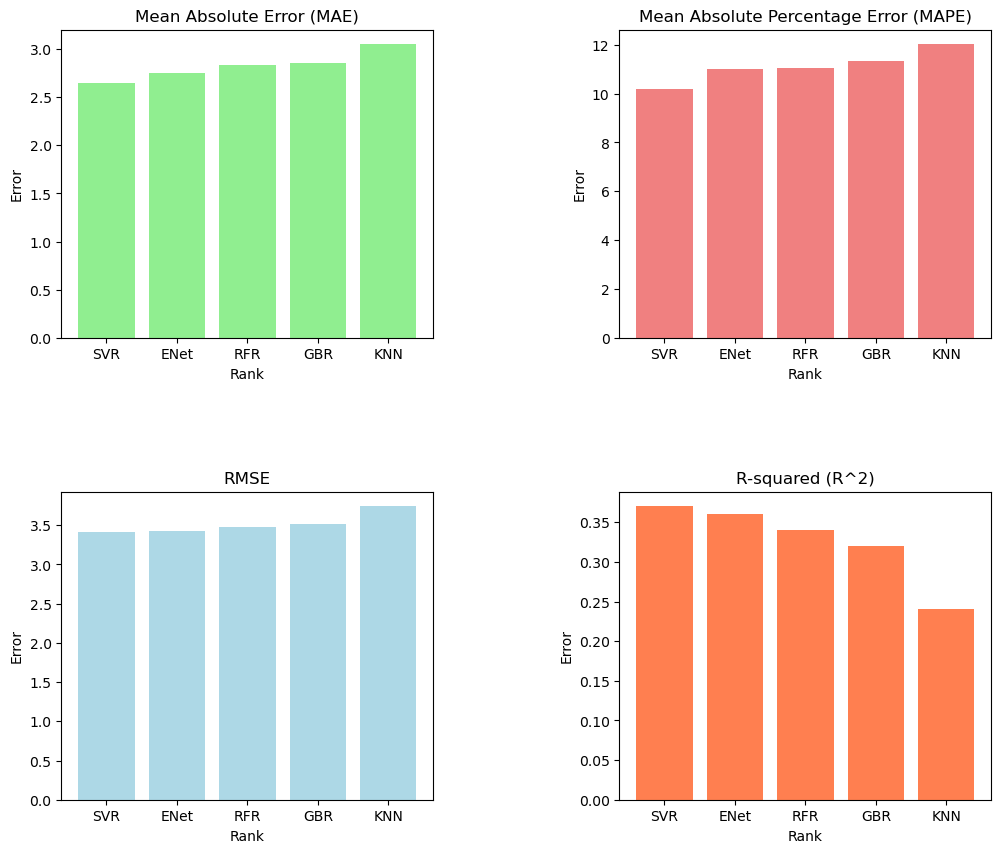

In [104]:
#Subplots of RMSE,R2,MAE,MAPE for five best performing models
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
rmse_list = []
r2_list = []
mae_list = []
mape_list = []

# Iterate over the best models according to rank
for rank, (name, model_info) in enumerate(sorted_models, start=1):
    model = model_info['hyperparameters']
    model.fit(X_train_i_s,y_train_i)
    y_pred = model.predict(X_test_i_s)
    y_pred_reshape = y_pred.reshape(40,1)
    mse = mean_squared_error(y_test_i, y_pred)
    r2 = r2_score(y_test_i, y_pred)
    mae = mean_absolute_error(y_test_i, y_pred)
    mape = mean_absolute_percentage_error(y_test_i, y_pred) * 100

    rmse_list.append(round(np.sqrt(mse),2))
    r2_list.append(round(r2,2))
    mae_list.append(round(mae,2))
    mape_list.append(round(mape,2))
    
    
# MAE subplot
axs[0, 0].bar(models_name, mae_list, color='lightgreen')
axs[0, 0].set_title("Mean Absolute Error (MAE)")
axs[0, 0].set_xlabel("Rank")
axs[0, 0].set_ylabel("Error")

# RMSE subplot
axs[1, 0].bar(models_name, rmse_list, color='lightblue')
axs[1, 0].set_title("RMSE")
axs[1, 0].set_xlabel("Rank")
axs[1, 0].set_ylabel("Error")

# R^2 subplot
axs[1, 1].bar(models_name, r2_list, color='coral')
axs[1, 1].set_title("R-squared (R^2)")
axs[1, 1].set_xlabel("Rank")
axs[1, 1].set_ylabel("Error")

# MAPE subplot
axs[0, 1].bar(models_name, mape_list, color='lightcoral')
axs[0, 1].set_title("Mean Absolute Percentage Error (MAPE)")
axs[0, 1].set_xlabel("Rank")
axs[0, 1].set_ylabel("Error")

summary = {"Models":models_name,"MAE":mae_list,"MAPE":mape_list,"RMSE":rmse_list,"R^2":r2_list}
score_summary = pd.DataFrame(summary)
score_summary

**Saving preprocessors and the five best performing models for Deployment**

In [105]:
# Save the models
for i, (model_name, model) in enumerate(best_models.items()):
    with open(f'model_{i}.sav', 'wb') as file:
        pickle.dump(model, file)